In [24]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b1' 

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=50)

240
Loaded pretrained weights for efficientnet-b1


In [25]:
batch_size  = 64
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

In [26]:
# make dataset
from torchvision import transforms, datasets
data_path = 'data/ic/images'  
ic_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((240, 240)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))

In [27]:
# data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(ic_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(ic_dataset, train_idx)
tmp_dataset       = Subset(ic_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

In [28]:
# data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4) 
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4) 
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4) 
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 16,  tvt : 250 / 32 / 32


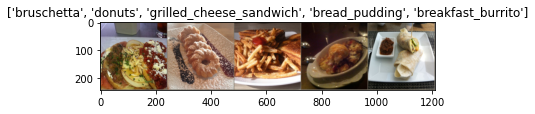

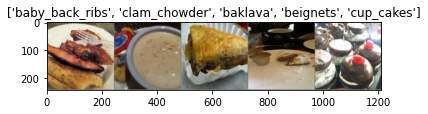

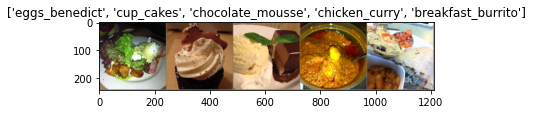

In [29]:
# data check
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "apple_pie",      
    "1": "baby_back_ribs",   
    "2": "baklava",   
    "3": "beef_carpaccio", 
    "4": "beef_tartare",   
    "5": "beet_salad",   
    "6": "beignets",  
    "7": "bibimbap",      
    "8": "bread_pudding",   
    "9": "breakfast_burrito",   

    "10": "bruschetta", 
    "11": "caesar_salad",   
    "12": "cannoli",   
    "13": "caprese_salad",  
    "14": "carrot_cake",      
    "15": "ceviche",   
    "16": "cheese_plate",   
    "17": "cheesecake", 
    "18": "chicken_curry",   
    "19": "chicken_quesadilla",   

    "20": "chicken_wings",  
    "21": "chocolate_cake",      
    "22": "chocolate_mousse",   
    "23": "churros",   
    "24": "clam_chowder", 
    "25": "club_sandwich",   
    "26": "crab_cakes",   
    "27": "creme_brulee",  
    "28": "croque_madame",      
    "29": "cup_cakes",   

    "30": "deviled_eggs",   
    "31": "donuts", 
    "32": "dumplings",   
    "33": "edamame",   
    "34": "eggs_benedict",  
    "35": "escargots",      
    "36": "falafel",   
    "37": "filet_mignon",   
    "38": "fish_and_chips", 
    "39": "foie_gras",   

    "40": "french_fries",   
    "41": "french_onion_soup",   
    "42": "french_toast", 
    "43": "fried_calamari",   
    "44": "fried_rice",   
    "45": "frozen_yogurt",   
    "46": "garlic_bread", 
    "47": "gnocchi",   
    "48": "greek_salad",   
    "49": "grilled_cheese_sandwich"
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'ic_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [32]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 3.10 Acc: 21.2
valid Loss: 3.91 Acc: 9.0
==> best model saved - 0 / 9.0
Epoch 1/29
----------
train Loss: 2.26 Acc: 39.5
valid Loss: 3.14 Acc: 28.2
==> best model saved - 1 / 28.2
Epoch 2/29
----------
train Loss: 1.75 Acc: 51.3
valid Loss: 2.82 Acc: 33.6
==> best model saved - 2 / 33.6
Epoch 3/29
----------
train Loss: 1.37 Acc: 61.7
valid Loss: 3.24 Acc: 28.6
Epoch 4/29
----------
train Loss: 1.02 Acc: 70.7
valid Loss: 2.50 Acc: 39.4
==> best model saved - 4 / 39.4
Epoch 5/29
----------
train Loss: 0.87 Acc: 74.2
valid Loss: 3.27 Acc: 36.6
Epoch 6/29
----------
train Loss: 0.66 Acc: 80.5
valid Loss: 2.84 Acc: 38.6
Epoch 7/29
----------
train Loss: 0.48 Acc: 84.8
valid Loss: 3.29 Acc: 38.4
Epoch 8/29
----------
train Loss: 0.40 Acc: 87.6
valid Loss: 4.32 Acc: 30.4
Epoch 9/29
----------
train Loss: 0.30 Acc: 90.9
valid Loss: 2.96 Acc: 40.2
==> best model saved - 9 / 40.2
Epoch 10/29
----------
train Loss: 0.29 Acc: 91.2
valid Loss: 3.64 Acc: 38.0
Epoch

best model : 29 - 58 / 2.0


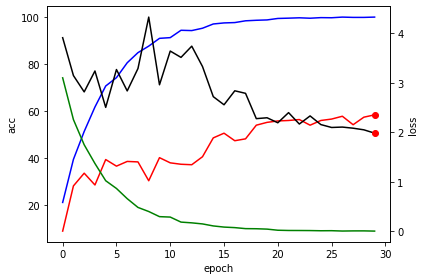

In [33]:
# 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [34]:
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로

test done : loss/acc : 2.14 / 58.8


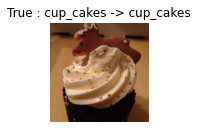

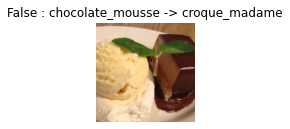

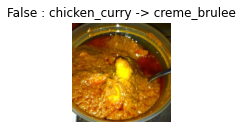

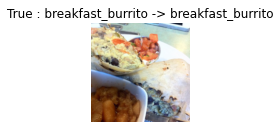

In [35]:
    ## TEST!
    test_and_visualize_model(model, phase = 'test')